<a href="https://colab.research.google.com/github/E-B-Manohar/Object-Classification-with-Keras-using-Transfer-Learning/blob/master/DL_CUTE_Colab_Manual_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Modules to ignore warnings
import warnings               
warnings.filterwarnings('ignore')

import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

import os   
import shutil
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline
from subprocess import call

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from keras.models import Sequential, Model, load_model
from keras.layers import *
from keras.optimizers import Adam, SGD
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.applications.inception_v3 import InceptionV3
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.utils import to_categorical

Using TensorFlow backend.


In [0]:
train_path = '/content/drive/My Drive/Colab Notebooks/10_categories'   # Train data path
classes = os.listdir(train_path)                          # List of directories in train path
print(classes)

['car_side', 'watch', 'Faces_easy', 'airplanes', 'Leopards', 'Motorbikes', 'BACKGROUND_Google', 'Faces', 'bonsai', 'grand_piano']


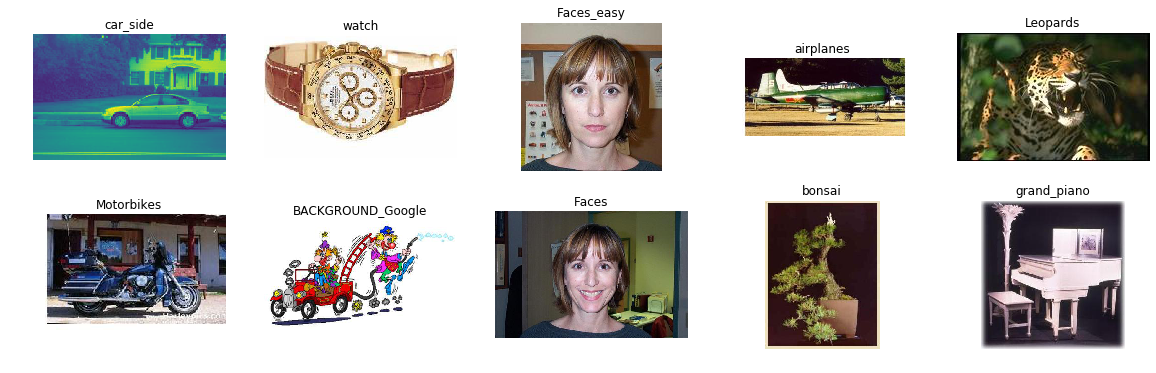

In [0]:
# Plot a sample image from each category

plt.figure(figsize=(20,6))
for ix,i in enumerate(classes):
    f = os.listdir(os.path.join(train_path,i))[80]
    img = mpimg.imread(os.path.join(train_path,i,f))
    plt.subplot(2,5,ix+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(i)

In [0]:
for ix,i in enumerate(classes):
    print(i,"\n",len(os.listdir(os.path.join(train_path,i))))

car_side 
 712
watch 
 823
Faces_easy 
 731
airplanes 
 828
Leopards 
 775
Motorbikes 
 798
BACKGROUND_Google 
 759
Faces 
 730
bonsai 
 708
grand_piano 
 689


In [0]:
# This is the augmentation configuration we will use for training
data_generator = ImageDataGenerator(rescale=1/255.,
                                    rotation_range=20,
                                    height_shift_range=0.2,
                                    validation_split = 0.2,
                                    zoom_range=0.2)

# This is a generator that will read pictures found in subfolers of 'train', and generates
# batches of augmented image data on the fly
train_generator = data_generator.flow_from_directory(directory=train_path,
                                                    batch_size=128, 
                                                    class_mode='categorical', 
                                                    shuffle=True,
                                                    subset = "training",
                                                    target_size=(224,224))

val_generator = data_generator.flow_from_directory(directory=train_path,
                                                    batch_size=128,
                                                    class_mode='categorical', 
                                                    shuffle=True,
                                                    subset = "validation",
                                                    target_size=(224,224))

Found 6046 images belonging to 10 classes.
Found 1506 images belonging to 10 classes.


In [0]:
def image_classifier(nb_classes):
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(5, 5), input_shape=(224, 224, 3), padding='valid'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(filters=64, kernel_size=(5, 5), padding='valid'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(filters=128, kernel_size=(5, 5), padding='valid'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dropout(0.2))

    model.add(Dense(128, init='uniform', activation='relu'))
    model.add(Dropout(0.4))

    model.add(Dense(nb_classes, activation='softmax'))
    
    return(model)

In [0]:
model = image_classifier(nb_classes=10)
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

In [0]:
chkp = ModelCheckpoint(filepath='image_classifier.h5', monitor='val_loss', save_best_only=True, save_weights_only=False, verbose=0)

hist0 = model.fit_generator( train_gen, steps_per_epoch = 82,   
                             validation_data=val_gen, validation_steps = 35, 
                          #  callbacks= [chkp],
                             epochs=500).history